# Finding pumps that give locally optimal spectral purity

This notebook showcases a local optimization scheme applied on mode purity for SPDC phenomenon in waveguides. The constraint on mean number of photon pair per pump pulse (gain) and on the center frequency of the pump will be imposed using a penalty method and the constraint on the variance of pump will be imposed using a regularization method.

## Import the libraries 

The library used to generate initial seed, to optimize the spectral purity and to post-process the data are imported.

In [1]:
import jax.numpy as jnp
import jax
import jaxopt
import numpy as np
import scipy

import matplotlib.pyplot as plt

import optimization_SPDC as opt
import optimization_quadratures as opt_quad
import get_initialization_cond as init


key = jax.random.PRNGKey(0)
#from jax.config import config
#config.update("jax_enable_x64", True)
jax.config.update("jax_enable_x64", True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Case where the pump has a frequency dependant phase

## Set general hyperparameters

Hyperparameters define the frequency range, length of waveguide, group velocities and gain

In [2]:
N = 201
wi = -10
wf = 10
delta_omega = (wf - wi)/N
x = jnp.linspace(wi, wf, N)
vp = 0.1
l = 1
y_N = 0.5

## Define phase matching matrices and initialize the pump

In [3]:
G, H = init.get_constants(vp, l, wi, wf, N = N)
random_seed = 0.1*delta_omega*jax.random.uniform(key, shape=(4*N - 2,))
gaussian_seed = 0.001*delta_omega*jnp.array(list(np.exp(-np.linspace(x[0], x[-1], 2*N - 1)**2/.5)) + list(np.exp(-np.linspace(x[0], x[-1], 2*N - 1)**2/.5)))

(Array(3.86375127e-06, dtype=float64), Array(1.21830831, dtype=float64))

## Perform BFGS with penalty method and regularization on pump variance

In [15]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=opt.problem, maxiter=2000, jit = True)
pump = random_seed.copy()
for i in range(10):
    print("run " + str(i))
    print("observables: ", opt.get_observables(pump, N, G, H, l))
    (pump, state) = solver.run(pump, x, G, H, l, y_N, 5**i)

run 0
observables:  (Array(0.29128919, dtype=float64), Array(14.84103648, dtype=float64))
53.25400114059448
BFGS:  0
observables:  (Array(1.20907539, dtype=float64), Array(1.4128639, dtype=float64))


KeyboardInterrupt: 

# Quadratures

In [2]:
N = 201
wi = -10
wf = 10
omega = np.linspace(wi, wf, N)
delta_omega = np.abs(omega[1] - omega[0])
vp = 0.1
l = 1
Np = 0.01
G, H = init.get_constants(vp, l, wi, wf, Np, N = N)
delta_k = 1.j*G
y_N = 1.
opt_quad.get_observables(gaussian_seed, N, delta_k, l)

(Array(0.01947283, dtype=float64), Array(1.21603413, dtype=float64))

In [3]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=opt_quad.problem, maxiter=5000, jit = False)

In [4]:
# Try reducing the penalty term
pump = random_seed.copy()
pumps_for_k = []
for i in range(5):
    print("run " + str(i))
    print("observables: ", opt_quad.get_observables(pump, N, delta_k, l))
    (pump, state) = solver.run(pump, omega, delta_k, l, y_N, 5**i)

run 0
observables:  (Array(0.13250503, dtype=float64), Array(15.58651777, dtype=float64))
BFGS:  0
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
BFGS:  1
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
BFGS:  2
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
run 1
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
BFGS:  0
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
BFGS:  1
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
BFGS:  2
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
run 2
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
BFGS:  0
observables:  (Array(1.00242965, dtype=float64), Array(1.14302504, dtype=float64))
BFGS:  1
observables:  (Array(1.00072715, dtype=float64), Array(1.14310396, dtype=float6

## Optimization of a Gaussian

Now, suppose the optimal pump is truly Gaussian, only 3 parameters are needed, which are the amplitude of the Gaussian, its width and the phase for a complex pump. Let us generate the seeds for these 3 parameters. First, we need to import the modules to realize the optimization scheme.

In [6]:
import optimization_SPDC_gaussain_pump as opt_gauss

Now, let us use the same parameters for the Gaussian seed to generate an optimization scheme restricted to Gaussian pumps and the same solver as before with penalty method.

In [24]:
params = [gaussian_amplitude, gaussian_width, phase]
gauss_solver = jaxopt.ScipyMinimize(method = "BFGS", fun=opt_gauss.get_penalty_loss, maxiter=20, jit= False)
theta = params.copy()
for i in range(15):
    print("run number " + str(i))
    (theta, state) = gauss_solver.run(theta, freq_range_pump, alpha, G, H, l, y_N, 3**i)

run number 0
run number 1
run number 2
run number 3
run number 4
run number 5
run number 6
run number 7
run number 8
run number 9
run number 10
run number 11
run number 12
run number 13
run number 14


Comparing the normalized absolute value of the optimal pump when pump values were arbitrary and the optimal pump when restricted to a Gaussian, one can see that the shape is almost identical.

In [32]:
Nownorm_gauss_pump = jnp.abs(opt_gauss.get_gaussian_pump(theta, freq_range_pump))/jnp.linalg.norm(opt_gauss.get_gaussian_pump(theta, freq_range_pump))
norm_arb_hermitian_pump = (abs_hermit_pump/jnp.linalg.norm(abs_hermit_pump))
comparison_leg = ["optimal pump when every element is a parameter", "optimal Gaussian pump"]

(DeviceArray(3.0009482, dtype=float32), DeviceArray(1.088198, dtype=float32))

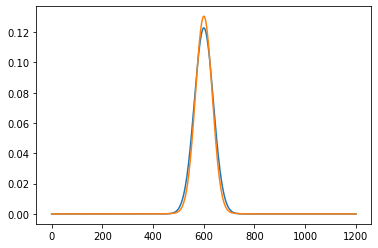

In [33]:
disp.plot_pump([norm_gauss_pump, norm_arb_hermitian_pump], freq_range_pump, comparison_leg)

Doing the cross correlation between the optimal pump, one realizes that the likelihood is 

In [37]:
print("Normalized cross correlation between the Gaussian pump and the arbitrary pump is " + str(norm_gauss_pump@norm_arb_hermitian_pump))

Normalized cross correlation between the Gaussian pump and the arbitrary pump is 0.996406


This result is interesting, because for low gain ($n \ll 1$), it has been proven analytically through perturbative regime that to obtain purely separable joint spectral amplitude, a Gaussian phase matching function and a Gaussian pump are needed (Quesada and Branczyk, 2018). A numerical optimization scheme was performed with an objective function stemming from low-gain regime, which is a restricted case of the general SPDC in waveguides. Let us compare how does the optimal pump obtained theorically fare in high gain regime with the Gaussian pumps obtained with optimization at high gain.

# Comparing low gain optimal pump at high gain with optimized pump at this high gain

A main difference between the low-gain regime and high gain regime is the presence of higher Fock state terms in the output state. If the phase matching function (PMF) is not Gaussian, an approximation that is closest to a Gaussian is preferable. For a sinc PMF of the form $\frac{\sin \left(\kappa (x-y)\right)}{x-y}$, the width of the Gaussian should be of $\frac{1.61}{1.13}\kappa$ to have maximal separability. Let us generate a pump with such a width.

In [29]:
ratio = 1.61/1.13
vi = vp / (1 - 2 * ratio * vp / l)
vs = vp / (1 + 2 * ratio * vp / l)
width = jnp.sqrt(ratio/(l*(1/vp - 1/vi)))
theta = [0.01, width, 0.1]
low_pump = opt_gauss.get_gaussian_pump(theta,freq_range_pump)

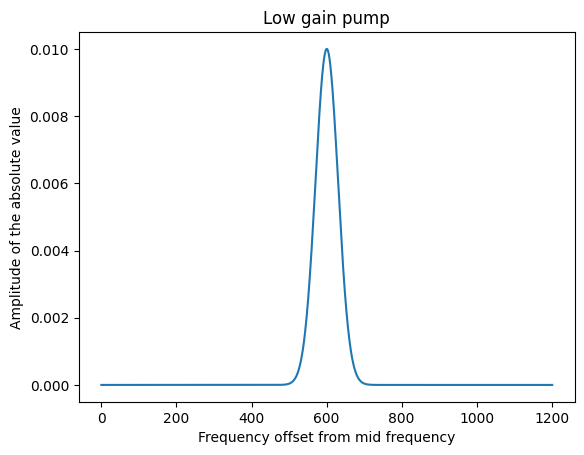

In [32]:
plt.title("Low gain pump")
plt.xlabel("Frequency offset from mid frequency")
plt.ylabel("Amplitude of the absolute value")
plt.plot(np.abs(low_pump))

The joint spectral amplitude would look like

In [ ]:
JSA = gauss_opt.get_JSA(theta, freq_range_pump, alpha, G, H, l)
fig, ax = plt.subplots()
im = ax.imshow(JSA, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_title("JSA with 10 N value")
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
plt.colorbar(im, orientation="vertical")
plt.show()Now

Now, let $n$ value taking the values $\{0.5, 1, 1.5, 2, 2.5, 3\}$, let us see what the optimized Gaussian pump should look like at these values

In [7]:
params = [gaussian_amplitude, gaussian_width, phase]
gauss_solver = jaxopt.ScipyMinimize(method = "BFGS", fun=opt_gauss.get_penalty_loss, maxiter= 10, jit= False)

In [8]:
y_Ns = [0.5, 1., 1.5, 2., 2.5, 3.]
theta_per_y_N = []
for n in y_Ns:
    theta = params.copy()
    for i in range(15):
        print("run number " + str(i))
        (theta, state) = gauss_solver.run(theta, freq_range_pump, alpha, G, H, l, n, 3**i)
        theta_per_y_N.append(theta.copy())

run number 0
run number 1



KeyboardInterrupt



In [ ]:
diff_n_schmidt_numbers = []
for i in range(len(theta_per_y_N)):
    diff_n_schmidt_numbers.append(opt_gauss.get_observables(theta_per_y_N[i], freq_range_pump, alpha, G, H, l)[1])

For the same values of $n$, let us take Gaussian pumps with width optimized for low gain and find the Schmidt number associated with each case.

In [133]:
amps = [0.3845, 0.5068, 0.5856, 0.64356, 0.689181, 0.72667]
schmidt_numbers_low = []
for amp in amps:
    diff_theta = [amp, width, 0.1]
    schmidt_numbers_low.append(opt_gauss.get_observables(diff_theta, freq_range_pump, alpha, G, H, l)[1])

Now, we can compare them by plotting the Schmidt number as function of mean number of photon pairs per pulse

NameError: name 'diff_n_schmidt_numbers' is not defined

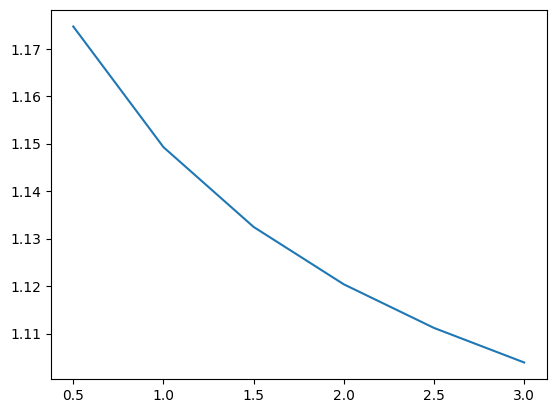

In [138]:
plt.plot(y_Ns, schmidt_numbers_low)
plt.plot(y_Ns, diff_n_schmidt_numbers)

Comparing the Schmidt number, we see that the pump optimized for low gain does not seem to be optimal for high gain.

# Optimizing with quadrature operators

In [18]:
import optimization_quadratures as quad_opt
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, alpha_phase, N = N)
pump = 0.1*jax.random.uniform(key=jax.random.PRNGKey(np.random.randint(999)), shape = (2*N,))
solver = jaxopt.ScipyMinimize(method="BFGS", fun=quad_opt.get_penalty_loss, maxiter=1, jit = False)

In [19]:
pumps_for_k = []
for i in range(20):
    pumps = []
    print("run " + str(i))
    for j in range(15):
        (pump, state) = solver.run(pump, N, alpha, H, l, freq_range_pump, y_N, 3**i)
        pumps.append(pump.copy())
    quad_opt.get_observables(pump, N, alpha, H, l)
    pumps_for_k.append(pumps)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19


In [34]:
best_pump = pumps_for_k[-1][-1]
W_plus, W_minus = quad_opt.get_propagators(best_pump, N, alpha, H, l)
J = 0.25*(W_plus@W_plus.conj().T + W_minus@W_minus.conj().T - 2*jnp.eye(N))
quad_opt.get_observables(best_pump, N, alpha, H, l)

(Array(2.9997458, dtype=float32), Array(1.0815665, dtype=float32))

In [42]:
np.real(W_plus@W_minus.conj().T) - np.eye(N)

Array([[-1.88052654e-04,  5.10445659e-08, -1.85755411e-10, ...,
         1.03409548e-08, -1.66319296e-08, -4.59734792e-08],
       [-7.80806531e-08, -4.83989716e-05, -2.55643684e-08, ...,
         1.23573045e-08, -7.90578270e-10,  8.91304808e-09],
       [-4.63171084e-08, -1.18812942e-08,  2.00510025e-04, ...,
         2.25736585e-09,  7.20319804e-10,  3.59887053e-09],
       ...,
       [-8.75297701e-09, -5.14319254e-10,  5.84350346e-09, ...,
        -2.55107880e-04,  2.20825314e-08, -2.18278728e-08],
       [-2.61484274e-08, -1.47838364e-08, -1.74668457e-08, ...,
        -1.86810212e-09,  5.65052032e-05,  5.82367647e-08],
       [-5.87756404e-08, -1.49848347e-08, -5.95700840e-08, ...,
        -2.71538738e-08,  8.69476935e-08, -1.43051147e-05]],      dtype=float32)

In [53]:
U_si

Array([[ 2.7509854e-04-2.2967939e-05j,  3.0196033e-04-1.8715127e-05j,
         6.1506624e-05+3.6841088e-06j, ...,
         2.0174048e-05+5.4287072e-04j,  7.0846290e-06+5.3598138e-04j,
        -5.6609861e-06+5.2862789e-04j],
       [ 3.0196065e-04-1.8715089e-05j,  6.1534556e-05+3.6968734e-06j,
         1.1695750e-04+2.9726530e-06j, ...,
         7.0310780e-06+5.3892244e-04j, -5.7888974e-06+5.3213781e-04j,
        -1.8271123e-05+5.2481209e-04j],
       [ 6.1506638e-05+3.6840881e-06j,  1.1695745e-04+2.9726393e-06j,
         6.2491643e-05+6.6050816e-06j, ...,
        -5.9132872e-06+5.3444010e-04j, -1.8467894e-05+5.2768498e-04j,
        -3.0682102e-05+5.2026095e-04j],
       ...,
       [ 2.0173407e-05+5.4287119e-04j,  7.0309616e-06+5.3892250e-04j,
        -5.9136655e-06+5.3443993e-04j, ...,
        -2.7987163e-04-2.7001975e-06j, -8.1756516e-05-1.5601529e-06j,
        -4.3755645e-05-1.1319376e-06j],
       [ 7.0840179e-06+5.3598173e-04j, -5.7894795e-06+5.3213775e-04j,
        -1.8468330e-05

In [55]:
-U_is

Array([[ 2.75098486e-04-2.2967910e-05j,  3.01960739e-04-1.8715107e-05j,
         6.15066601e-05+3.6841216e-06j, ...,
         2.01737857e-05+5.4287061e-04j,  7.08457083e-06+5.3598103e-04j,
        -5.66034578e-06+5.2862795e-04j],
       [ 3.01960215e-04-1.8715080e-05j,  6.15345634e-05+3.6968745e-06j,
         1.16957366e-04+2.9726448e-06j, ...,
         7.03133992e-06+5.3892174e-04j, -5.78921754e-06+5.3213711e-04j,
        -1.82712392e-05+5.2481127e-04j],
       [ 6.15066383e-05+3.6841111e-06j,  1.16957461e-04+2.9726589e-06j,
         6.24917157e-05+6.6050798e-06j, ...,
        -5.91319986e-06+5.3443958e-04j, -1.84677774e-05+5.2768475e-04j,
        -3.06821603e-05+5.2026066e-04j],
       ...,
       [ 2.01734947e-05+5.4287066e-04j,  7.03238766e-06+5.3892285e-04j,
        -5.91520802e-06+5.3443981e-04j, ...,
        -2.79871630e-04-2.7001975e-06j, -8.17564724e-05-1.5601693e-06j,
        -4.37556446e-05-1.1319430e-06j],
       [ 7.08483276e-06+5.3598150e-04j, -5.78950858e-06+5.3213845e-0

In [59]:
# There is a phase problem in the quadratures
-0.5*1.j*(W_plus - W_minus)

Array([[ 2.76297331e-04+2.7872622e-05j,  3.01962456e-04+1.8714665e-05j,
         6.15085810e-05-3.6841666e-06j, ...,
         2.01749208e-05-5.4286985e-04j,  7.08513835e-06-5.3597987e-04j,
        -5.66047675e-06-5.2862702e-04j],
       [ 3.01962573e-04+1.8714694e-05j,  6.18696213e-05+1.6465783e-06j,
         1.16959694e-04-2.9717630e-06j, ...,
         7.03112164e-06-5.3892191e-04j, -5.78875188e-06-5.3213607e-04j,
        -1.82707881e-05-5.2481098e-04j],
       [ 6.15085955e-05-3.6841084e-06j,  1.16959658e-04-2.9718503e-06j,
         6.36279583e-05-1.5823171e-06j, ...,
        -5.91286516e-06-5.3443859e-04j, -1.84679666e-05-5.2768382e-04j,
        -3.06818984e-05-5.2026031e-04j],
       ...,
       [ 2.01743533e-05-5.4287072e-04j,  7.03125261e-06-5.3892343e-04j,
        -5.91311255e-06-5.3443934e-04j, ...,
        -2.79814005e-04+2.8912909e-06j, -8.17565378e-05+1.5602272e-06j,
        -4.37556519e-05+1.1319717e-06j],
       [ 7.08449807e-06-5.3598057e-04j, -5.78837353e-06-5.3213671e-0

In [32]:
not_quad_pump = jnp.concatenate((best_pump, jnp.zeros(len(best_pump))))
U_ss, U_si, U_is, U_ii = opt.get_submatrices(not_quad_pump, N, alpha, G, H, l)
N_mat = U_si.conj().T@U_si
N_mat

Array([[ 7.3343945e-05-2.8421709e-14j,  7.3521827e-05+1.6276224e-06j,
         7.3714924e-05+3.2633459e-06j, ...,
        -1.2279353e-06+6.3588886e-06j, -1.3680116e-06+6.5634972e-06j,
        -1.5025475e-06+6.6000571e-06j],
       [ 7.3521827e-05-1.6276231e-06j,  7.4017524e-05-1.1723955e-13j,
         7.4198266e-05+1.6408234e-06j, ...,
        -1.1032315e-06+6.0589236e-06j, -1.2304730e-06+6.2718118e-06j,
        -1.3566353e-06+6.3183757e-06j],
       [ 7.3714924e-05-3.2633459e-06j,  7.4198266e-05-1.6408237e-06j,
         7.4698153e-05-8.7041485e-14j, ...,
        -9.9398665e-07+5.7360617e-06j, -1.1076992e-06+5.9572362e-06j,
        -1.2245256e-06+6.0132925e-06j],
       ...,
       [-1.2279353e-06-6.3588882e-06j, -1.1032315e-06-6.0589236e-06j,
        -9.9398665e-07-5.7360608e-06j, ...,
         1.0546925e-05+2.1649349e-14j,  1.0405582e-05+2.3482211e-07j,
         1.0277930e-05+4.6380660e-07j],
       [-1.3680116e-06-6.5634972e-06j, -1.2304730e-06-6.2718113e-06j,
        -1.1076992e-06

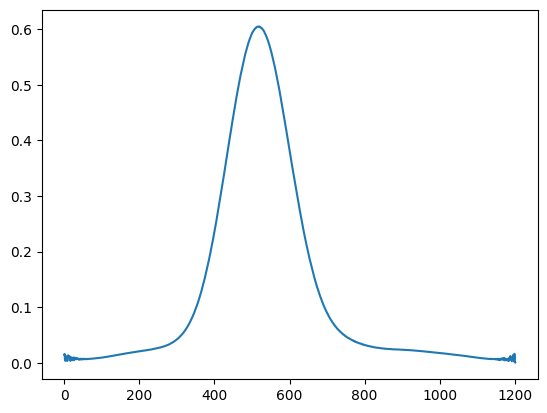

In [25]:
plt.plot(best_pump)